In [47]:
%matplotlib inline
from IPython.display import HTML,Image,SVG,YouTubeVideo


# Image representation

A digital image is discrete. It means that there is somewhere in the acquisition process, most of the time, sampling that occurs.

A digital image is basically a multidimentionnal array of numbers. Each picture element store a numerical value, with 2D images we speak about **pixels** (from PIcture ELements) and for 3D images we use **voxels** (from VOlume ELements).

The latice of pixels are usually rectangular (or square if pixels are squares) or hexagonal, hexagonal latice has a unique distance between a pixel and its neghboors.

The image dimentionnality will depend on:

* the spatial dimentionnality: 1D or profile, 2D image, 3D volume

* the temporal dimension: add one dimension for the time when dealing with **sequences**

* the spectral dimension: the number of spectral values associated with on image element


The spatial dimension is given, typically, by the grid step of the sensor. A 640x480 CMOS sensor will produce a 640x480 pixels grid.

For a flatbed scanner, one dimension will be given by the number of sensor along the acquisition line, while the second dimension will be given by the spatial repetition of a line acquisition.

One remark concerning these images: the shape of the pixels is not always a square, depending on the sensor geometry and/or the sampling speed (i.e.for the scanners).
One have to pay attention to that, in particular when we will extract measures from images (e.g. distance or surface).

When acquisition is a sequence one add one dimension for the time. 

Similarily, image can be composed of different spectral band.

For example, a time-lapse acquisition of fluorescent confocal microscopy can have 5-D:
* three X,Y and Z spatial dimensions (voxels)
* one spectral dimension , i.e. several fluorophore channels (e.g. dapi, alexa, GFP)
* one time dimension (time-lapse)

In [48]:
# add example of embryo

# Image sampling



C:\Users\alexa\AppData\Local\Temp\ipykernel_13820\4025397412.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


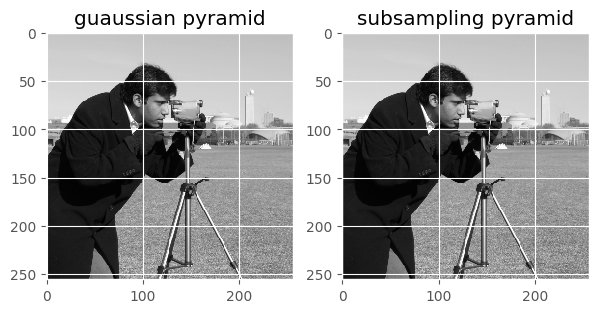

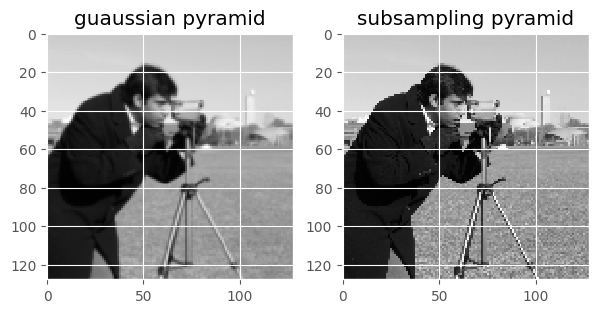

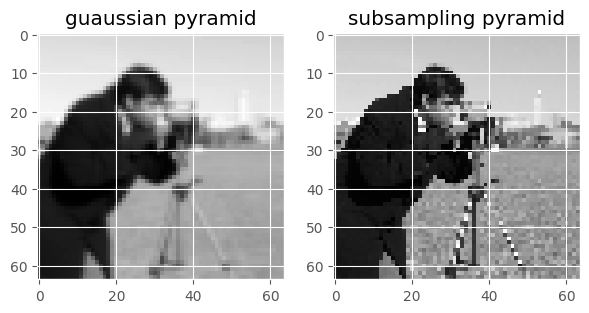

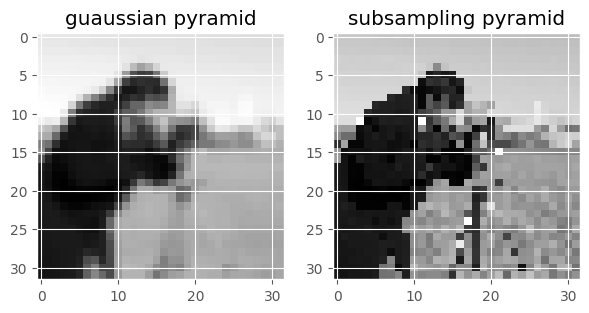

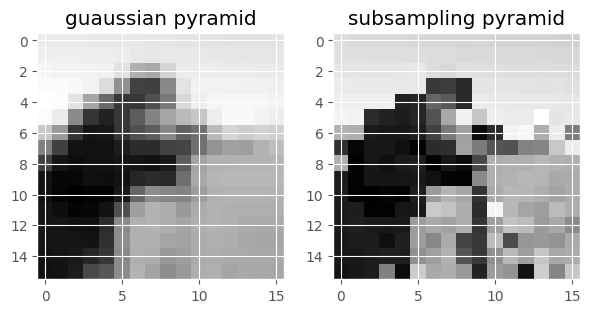

In [49]:
from scipy.ndimage.filters import gaussian_filter
from skimage.data import camera
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def build_gaussian_pyramid(ima,levelmax):
    """return a list of subsampled images (using gaussion pre-filter
    """
    r = [ima]
    current = ima
    for level in range(levelmax):
        lp = gaussian_filter(current,1.0)
        sub = lp[::2,::2]
        current = sub
        r.append(current)
    return r

def build_pyramid(ima,levelmax):
    """return a list of subsampled images (using gaussion pre-filter
    """
    r = [ima]
    current = ima
    for level in range(levelmax):
        sub = current[::2,::2]
        current = sub
        r.append(current)
    return r

im = camera()[::2,::2]

#build filtered and non-filtered pyramids
N = 4
fpyramid = build_gaussian_pyramid(im,N)
nfpyramid = build_pyramid(im,N)

for f,nf in zip(fpyramid,nfpyramid):

    plt.figure(figsize=[7,7])
    plt.subplot(1,2,1)
    plt.imshow(f,cmap=plt.cm.gray,interpolation='nearest')
    plt.title('guaussian pyramid')
    plt.subplot(1,2,2)
    plt.imshow(nf,cmap=plt.cm.gray,interpolation='nearest')
    plt.title('subsampling pyramid')


# Level sampling

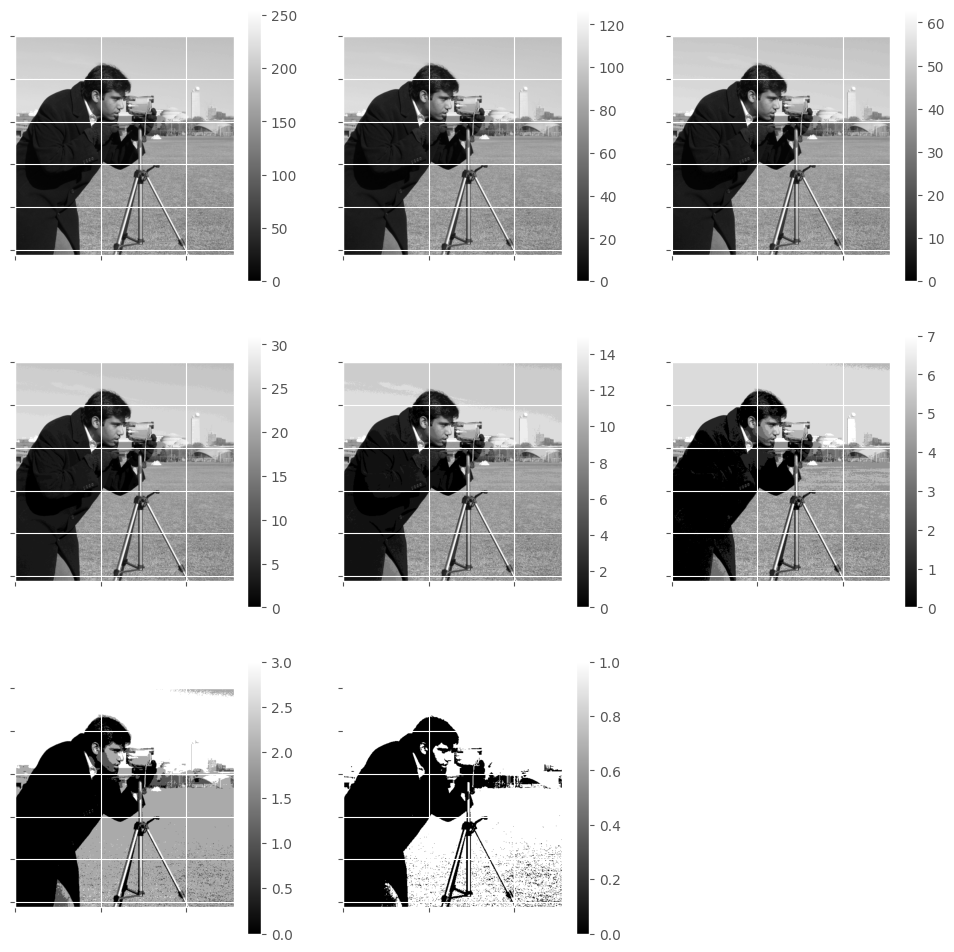

In [50]:
g = camera()
plt.figure(figsize=[12,12])
    
for s in range(0,8):
    g_poster = (g>>s)

    plt.subplot(3,3,s+1)
    plt.imshow(g_poster,cmap=cm.gray)
    plt.colorbar()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    

# Information

Entropy of a signal is given by:

$$e = -\sum_i {p_i \log {p_i}}$$

where $p_i$ is the probability of occurence of a symbol $i$.

For a gray scale image, one can consider the gray level distribution as the 'probablility' of occurence of a gray level. The following example illustrate how image entropy vary with respect to the graylevel distribution.

If the logarithm base used is 2, the entropy corresponds to the number of bits required to encode the signal.

> see also:
* image entropy **[IPAMV]** p19

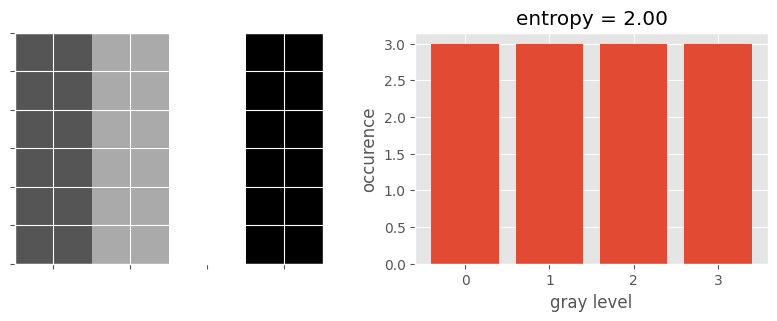

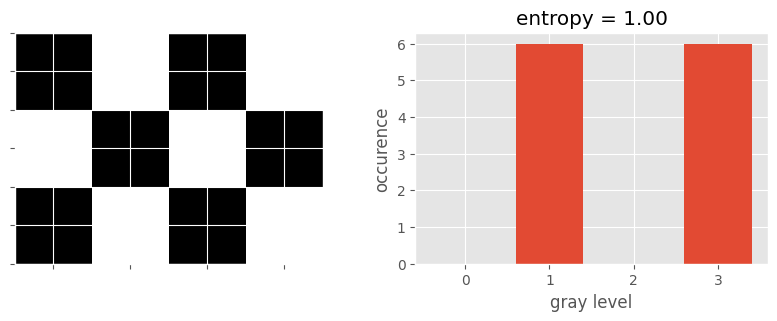

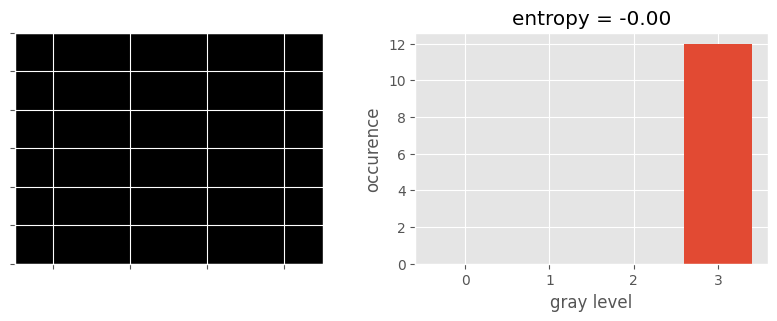

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.data import camera
plt.style.use('ggplot')

def display_hist(ima,nbin):
    hist,bins = np.histogram(ima.flatten(),bins=range(0,nbin+1))
    norm_hist = 1.*hist/np.sum(hist) # normalized histogram
    # entropy
    idx = norm_hist>0
    h = -np.sum(norm_hist[idx]*np.log2(norm_hist[idx]))
    
    # display the results
    plt.figure(figsize=[10,3])
    ax = plt.subplot(1,2,1)
    plt.imshow(ima,cmap=cm.gray,interpolation='nearest')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax = plt.subplot(1,2,2)
    plt.bar(bins[:-1],hist,.8)
    if len(bins)<10:
        ax.set_xticks(bins[:-1])
        ax.set_xticklabels( bins[:-1] )
    plt.xlabel('gray level')
    plt.ylabel('occurence');
    plt.title('entropy = %.2f'%h)
    
    
i1 = np.array([[1,2,3,0],[1,2,3,0],[1,2,3,0]])
i2 = np.array([[1,3,1,3],[3,1,3,1],[1,3,1,3]])
i3 = np.array([[3,3,3,3],[3,3,3,3],[3,3,3,3]])

display_hist(i1,4)
display_hist(i2,4)
display_hist(i3,4)

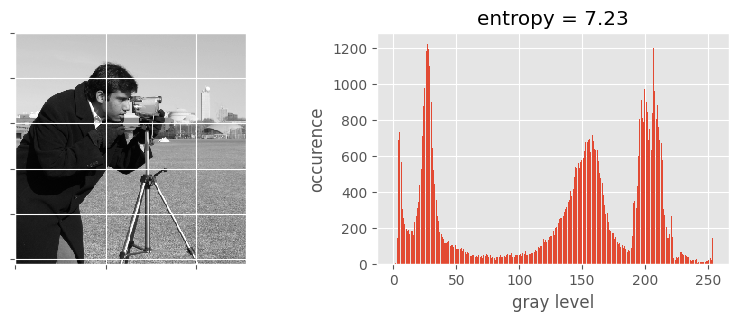

In [52]:
from skimage.data import camera
ima = camera()[::2,::2]
display_hist(ima,255)

The entropy of the above image is 7.05, it means that we need a bit more than 7 bits to encode graylevel for this image. Which is consistent with the choosen data storage (8 bit per pixel). 

Entropy is often known as an information measure.

But what would be the entropy of an image where all the pixels are randomly permuted ?

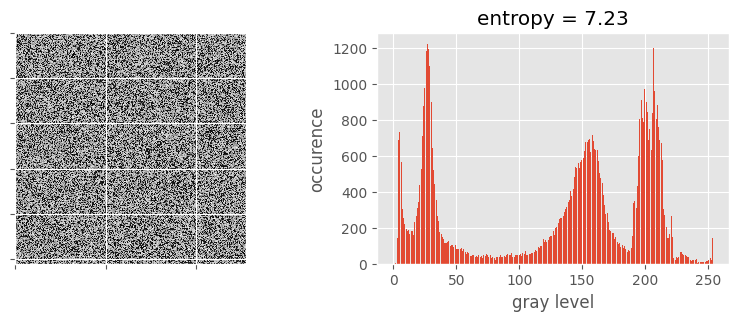

In [53]:
# randomly permutes all the image pixels
d = ima.flatten()
shuffled_ima = np.random.permutation(d.flatten())
shuffled_ima = shuffled_ima.reshape(ima.shape)

display_hist(shuffled_ima,255)

Since the entropy is computed on the graylevel **distribution**, nothing changes. So, from the entropy point of view, information carried by the above image is the same as the one of the cameraman, something about the way we define the information is wrong here...

In fact, when we shuffle the pixels of the image, we lose the localisation information, pixels that where located close to each other are splitted.

In order to take this colocality between pixels, one can use the coocurence matrix.

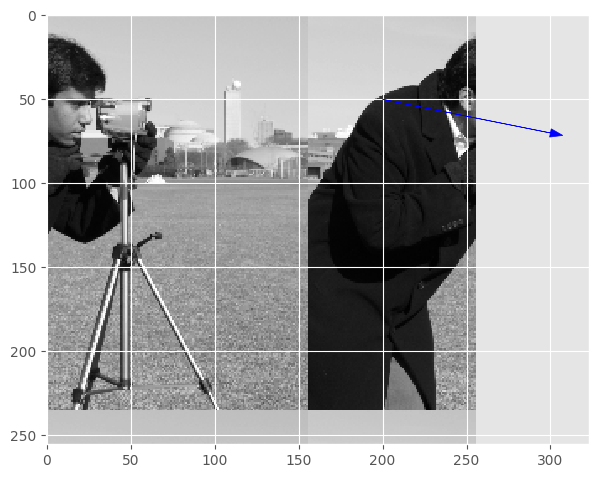

In [54]:
#coocurence matrix

def cooc(im,dx,dy):
    rim = np.roll(im,dy,axis=0)
    rim = np.roll(rim,dx,axis=1)
    G1 = im.flatten()
    G2 = rim.flatten()
    
    histo2D = np.zeros((256,256))

    for g1,g2 in zip(G1,G2):
        histo2D[g1,g2] = histo2D[g1,g2]+1
        
    return histo2D, rim

dx = -100
dy = -20
histo2D,rim = cooc(ima,dx=dx,dy=dy)
plt.figure(figsize=[7,7])
plt.imshow(rim,cmap=cm.gray,interpolation='nearest');
plt.arrow(200,50,-dx,-dy,color='b',head_width=5);

For an image $I$ one define a coocurance matrix by:
$$
C^{\Delta x, \Delta y}_{i,j}=\sum_{p=1}^n\sum_{q=1}^m\begin{cases} 1, & \text{if }I(p,q)=i\text{ and }I(p+\Delta x,q+\Delta y)=j \\ 0, &\text{otherwise}\end{cases}
$$

in other words, this matrix count the number of pixels having a gray level $i$ and its neighboor, defined by the $(\Delta x, \Delta y)$ translation, has a gray level $j$.

Usually close pixels share a similar gray level, for small $(\Delta x, \Delta y)$ the matrix is close to the diagonal.

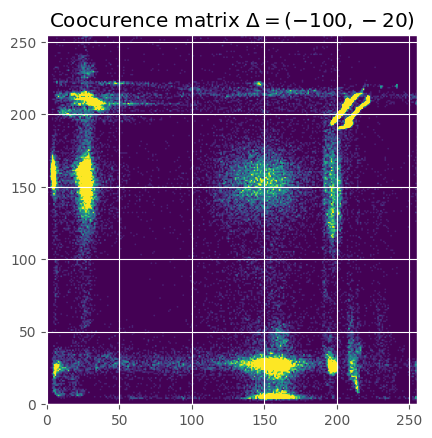

In [55]:
plt.imshow(histo2D,vmax=10)
plt.ylim([0,255])
plt.title('Coocurence matrix $\Delta = (%d,%d)$'%(dx,dy));

Exercice: 
1. what contains the diagonal of a coocurence matrix with $(\Delta x, \Delta y) = (0,0)$ ?

What about the impact of our previous shuffling on the coocurence matrix ?

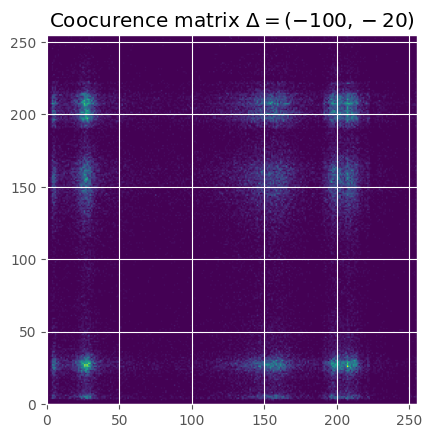

In [56]:
histo2D,_ = cooc(shuffled_ima,dx=dx,dy=dy)
plt.imshow(histo2D)
plt.ylim([0,255])
plt.title('Coocurence matrix $\Delta = (%d,%d)$'%(dx,dy));

Exercice:
1. evaluate the entropy of the coocurence matrices of the cameraman image 
2. do the same with its shuffled version.

> see also:
* cooccurence matrix **[IPAMV]** p45

# Compression

The aim of the compression can be to limit the size of the image in memory, for the storage, for the transmission. Depending n its use, compression can be lossless, i.e. the data remains untouched after decompression, or, the compression can be lossy if one tolerate some data degradation to have better compression. Image compression used redundancy present in the image to limit the actual number of bits to be used, for example continuity in an image, or in a sequence (video compression).

## Lossless compression
We give here two examples of compression that can be used to diminish the amount of bits to be used to store/transmit a data without changing its content.

### Huffman encoding
This method compress sequence of symbols (i.e. one can think of pixel graylevels) such that one take advantages of the unequal distribution if the occurence of symbols. Indeed if a symbol is very common, let's a gray level often used, it could be interesting to store its value with a very short (in terms of bits) symbol. On a contrary, a very rare symbol could use more bits without penalizing the average total message length.

In the given example here under, four symbols have a variable frequency of occurence, from a1 the most frequent to a4 the less one.

With the Huffman method we first associate the shortest code '0' to the most frequent symbol 'a1', all the other symbols will be coded by a word begining by '1'.

The same process is done recursively for the remaining symbols. Finally the rarest symbol will be coded by 3 bits, whereas normaly only 2 bits are sufficient for coding 1 symbol out of 4. But statistically, because a very short word is used for the most frequent symbol, the length of the total message will be shorter.

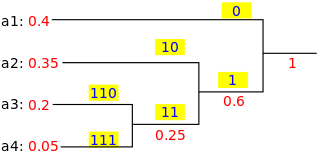

In [57]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Huffman_coding_example.svg/320px-Huffman_coding_example.svg.png')

<sup>[wikimedia commons](https://commons.wikimedia.org/wiki/File:Huffman_coding_example.svg)<sup>

Exercice:
1. apply the Huffman comression to a grayscale 8-bits image.

> see also:
* Huffman encoding **[DIPM]** pp261-269

### Run length encoding

When image is binary, one can group consecutive similar pixels (0 or 1) and encode them by saving the length of the sequence only. Of course the encoded image is stored in integer, big enough to store the longuest segment (35 in the given example).
If the image has a lot of continuous parts, this compression can be very efficient.

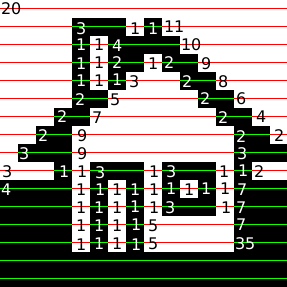

In [58]:
Image('http://pippin.gimp.org/image_processing/images/rle.png')

<sup>[image source](http://pippin.gimp.org/image_processing/images/rle.png)<sup>

Exercice:
1. propose a method for labelled image

> see also:
* Run-legth encoding **[IPH]** p396

### Image pyramid

How to better use the intrinsic image properties such as the continuity.



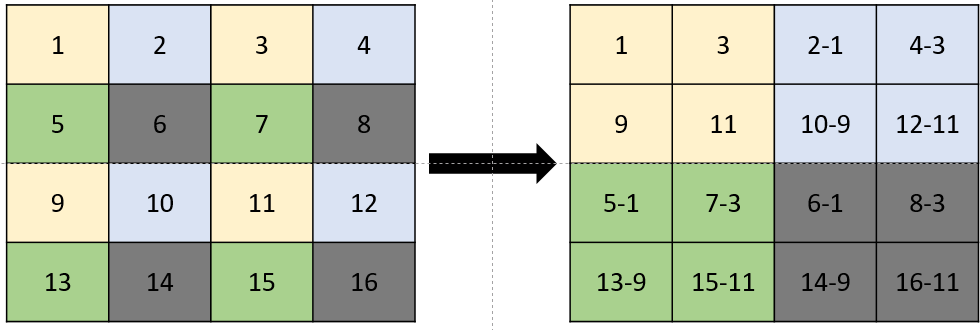

In [59]:
Image('PyramidCompression.png')

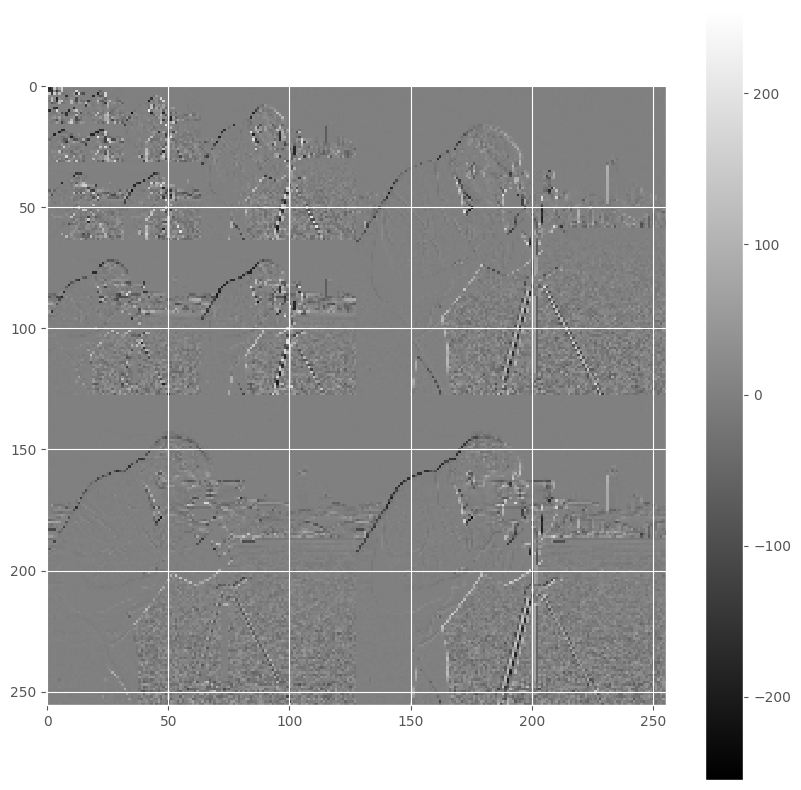

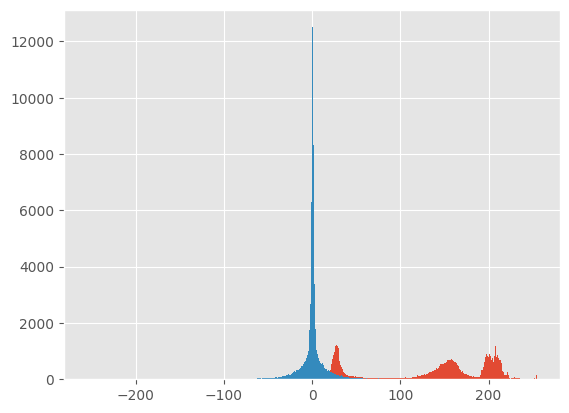

In [60]:

def split(im):
    if im.shape[0] > 1:
        a = im[0:-1:2,0:-1:2]
        b = im[0:-1:2,1::2]-a
        c = im[1::2,0:-1:2]-a
        d = im[1::2,1::2]-a
        R = np.vstack((np.hstack((split(a),b)),np.hstack((c,d))))
    else:
        R = im
    return R

im = camera()[::2,::2].astype("int")
s = split(im)

fig = plt.figure(figsize=[10,10])
plt.imshow(s,interpolation='nearest',cmap=cm.gray,vmin=-255, vmax=255)
plt.colorbar()

plt.figure()
h = plt.hist(im.flatten(),range(-256,256))[0]
h = plt.hist(s.flatten(),range(-256,256))[0]
#plt.plot(h)

Exercices : 

1. rebuild the original image from its compressed pyramid.
2. compute image entropy of the compressed pyramid

## Lossy image compression 
jpeg/dct

> see also:
* image pyramid (compression) **[DIPM]** p304
* lossy image compression (jpeg/dct) **[IPH]** p126

# Color representation

Color vision is due to the ability of the eye to discriminate three part of the spectrum thanks to specialized light sensitive cells, the cones. Color image are based on the same principle, the image is composed of the contributions of the light in several spectral bands. For usual picture these bands are red, green and blue. For the human vision, every color is a combination of these (additive) colors. 


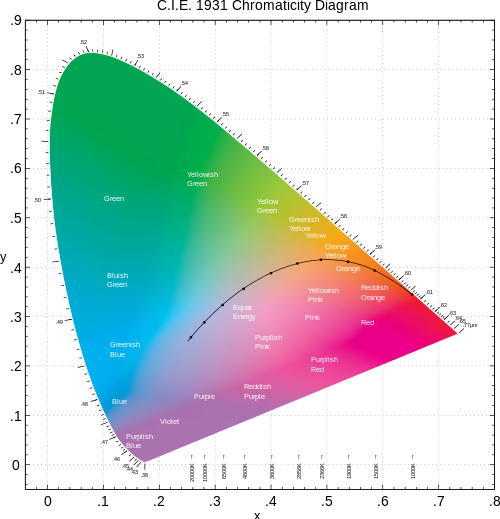

In [61]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/CIE-1931_diagram_in_LAB_space.svg/500px-CIE-1931_diagram_in_LAB_space.svg.png')

<sup>[wikimedia commons](https://commons.wikimedia.org/wiki/File:CIE-1931_diagram_in_LAB_space.svg)

## color systems

### RGB

Text(0.5, 1.0, 'rgb')

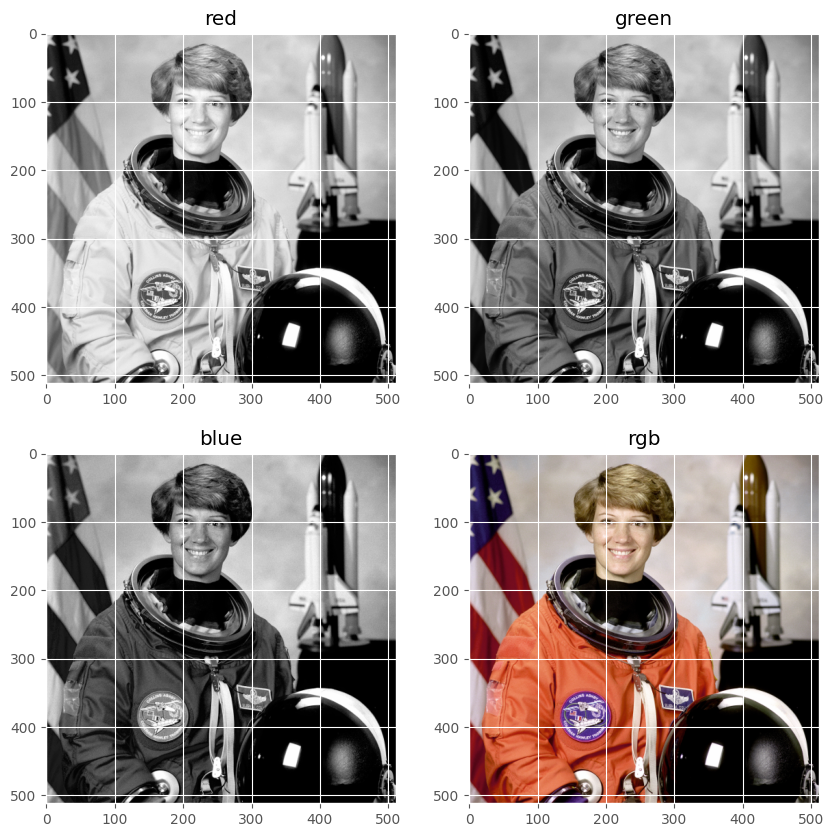

In [62]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import color
from skimage.data import astronaut,immunohistochemistry

rgb = astronaut()
plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.imshow(rgb[:,:,0],cmap=cm.gray)
plt.title('red')
plt.subplot(2,2,2)
plt.imshow(rgb[:,:,1],cmap=cm.gray)
plt.title('green')
plt.subplot(2,2,3)
plt.imshow(rgb[:,:,2],cmap=cm.gray)
plt.title('blue')
plt.subplot(2,2,4)
plt.imshow(rgb,cmap=cm.gray)
plt.title('rgb')


(512, 512, 3)


Text(0.5, 0, 'Blue')

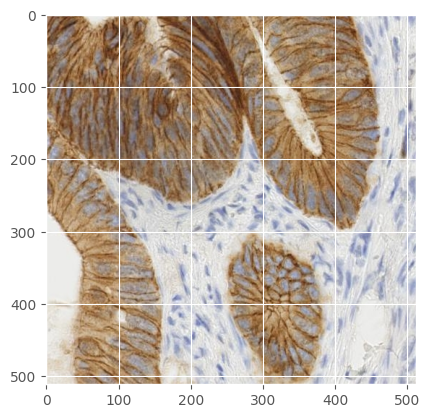

<Figure size 640x480 with 0 Axes>

In [63]:
rgb = immunohistochemistry()

fig = plt.figure(0)
plt.imshow(rgb,origin='lower')
plt.gca().invert_yaxis()

#subsample
print(rgb.shape)
rgb = rgb[::10,::10,:]

r = rgb[:,:,0].flatten()
g = rgb[:,:,1].flatten()
b = rgb[:,:,2].flatten()

fig = plt.figure()
ax = Axes3D(fig)
col = np.vstack((r,g,b)).T/255.0
ax.scatter(r,g,b,c=col)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

### HSV



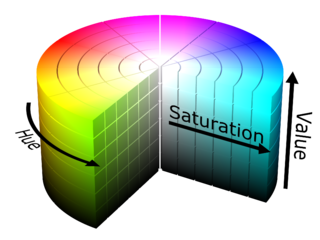

In [64]:
Image('https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/HSV_color_solid_cylinder.png/320px-HSV_color_solid_cylinder.png')

<sup>[wikimedia commons](https://commons.wikimedia.org/wiki/File:HSV_color_solid_cylinder_alpha_lowgamma.png)<sup>

In [65]:
hsv = color.rgb2hsv(rgb)

fig = plt.figure()
ax = Axes3D(fig)
h = hsv[:,:,0].flatten()
s = hsv[:,:,1].flatten()
v = hsv[:,:,2].flatten()
ax.scatter(h,s,v,c=col)
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value'),

(Text(0.5, 0, 'Value'),)

<Figure size 640x480 with 0 Axes>

### XYZ

In [67]:
xyz = color.rgb2xyz(rgb)
fig = plt.figure()
ax = Axes3D(fig)
x = s*np.cos(h*2*np.pi)
y = s*np.sin(h*2*np.pi)
z = v
ax.scatter(x,y,z,c=col)

th = np.linspace(0,6.28,200)
ax.scatter(np.cos(th),np.sin(th),0,c='k',s=.1);


<Figure size 640x480 with 0 Axes>